# **1. Importação das Bibliotecas**

In [ ]:
!pip install keras_tuner
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_tuner import Hyperband
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# **2. Carregar e Preparar os Dados**

In [ ]:
# Definir número de palavras do vocabulário
vocab_size = 10000  # Considera as 10.000 palavras mais frequentes
max_length = 200  # Tamanho máximo das sequências de entrada

# Carregar o dataset IMDB
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    # Remover HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remover caracteres especiais
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Converter para minúsculas
    text = text.lower()
    # Remover stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [w for w in words if w not in stop_words]
    # Lematização
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

# Carregar dataset
df = pd.read_csv('IMDB Dataset.csv')
df['cleaned_review'] = df['review'].apply(clean_text)

# Converter sentimentos para numéricos
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

texts = df["cleaned_review"].values
labels = df["sentiment"].values

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **3. Tokenização e Padronização**

Transforme os textos em sequências numéricas.

In [ ]:
# Definir parâmetros
MAX_VOCAB_SIZE = 10000  # Número máximo de palavras
MAX_SEQUENCE_LENGTH = 200  # Tamanho máximo da sequência

# Tokenização
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Exibindo o índice das palavras
print(tokenizer.word_index)

# Converter textos para sequências de inteiros
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

{'<OOV>': 1, 'movie': 2, 'film': 3, 'one': 4, 'like': 5, 'time': 6, 'good': 7, 'character': 8, 'get': 9, 'even': 10, 'story': 11, 'would': 12, 'make': 13, 'see': 14, 'really': 15, 'scene': 16, 'much': 17, 'well': 18, 'people': 19, 'great': 20, 'bad': 21, 'also': 22, 'show': 23, 'first': 24, 'dont': 25, 'way': 26, 'thing': 27, 'made': 28, 'could': 29, 'think': 30, 'life': 31, 'go': 32, 'know': 33, 'watch': 34, 'love': 35, 'many': 36, 'seen': 37, 'actor': 38, 'two': 39, 'plot': 40, 'say': 41, 'never': 42, 'look': 43, 'acting': 44, 'end': 45, 'little': 46, 'best': 47, 'year': 48, 'ever': 49, 'better': 50, 'take': 51, 'man': 52, 'come': 53, 'still': 54, 'work': 55, 'part': 56, 'find': 57, 'something': 58, 'want': 59, 'give': 60, 'lot': 61, 'back': 62, 'director': 63, 'im': 64, 'real': 65, 'guy': 66, 'watching': 67, 'doesnt': 68, 'performance': 69, 'didnt': 70, 'play': 71, 'woman': 72, 'actually': 73, 'though': 74, 'funny': 75, 'another': 76, 'nothing': 77, 'going': 78, 'role': 79, 'u': 80,

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Dividir o conjunto de treino em treino e validação (ex: 80% treino, 20% validação)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Tamanho do conjunto de treino:", len(X_train))
print("Tamanho do conjunto de validação:", len(X_val))
print("Tamanho do conjunto de teste:", len(X_test))
print("Tamanho do conjunto de treino subconjunto:", len(X_train_sub))

Tamanho do conjunto de treino: 40000
Tamanho do conjunto de validação: 8000
Tamanho do conjunto de teste: 10000
Tamanho do conjunto de treino subconjunto: 32000


# **4. Construção do Modelo LSTM**

In [ ]:
# Hiperparâmetros
EMBEDDING_DIM = 128
LSTM_UNITS = 64

# Criando o modelo
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(LSTM_UNITS, return_sequences=False),  # return_sequences=True se quiser empilhar mais LSTMs
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # Saída binária
])

# Compilar o modelo
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Exibir resumo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# **4. Busca de Hiperparâmetros para o Modelo LSTM**

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=MAX_SEQUENCE_LENGTH
    ))
    model.add(LSTM(hp.Choice('lstm_units', [32, 64, 128])))
    model.add(Dropout(hp.Choice('dropout', [0.3, 0.5, 0.7])))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

🔄 Rodando a busca:

In [ ]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperparam_search',
    project_name='lstm_imdb_tune'
)

tuner.search(X_train_sub, y_train_sub, validation_data=(X_val, y_val), epochs=10)

Trial 30 Complete [00h 02m 49s]
val_accuracy: 0.703000009059906

Best val_accuracy So Far: 0.8741250038146973
Total elapsed time: 00h 35m 14s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 200, 64)               │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (32, 128)                   │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 1)                     │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,945 (2.82 MB)

 Trainable params: 738,945 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

# **5. Treinamento do Modelo**

In [ ]:
EPOCHS = 5
BATCH_SIZE = 32

history = best_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9337 - loss: 0.1896 - val_accuracy: 0.9320 - val_loss: 0.1936
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9576 - loss: 0.1345 - val_accuracy: 0.9638 - val_loss: 0.1280
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9720 - loss: 0.0995 - val_accuracy: 0.9803 - val_loss: 0.0843
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9813 - loss: 0.0723 - val_accuracy: 0.9796 - val_loss: 0.0818
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9850 - loss: 0.0594 - val_accuracy: 0.9890 - val_loss: 0.0515


# **6. Avaliação do Modelo**

In [ ]:
# Predições
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Métricas
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(report)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.8664
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4961
           1       0.88      0.86      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



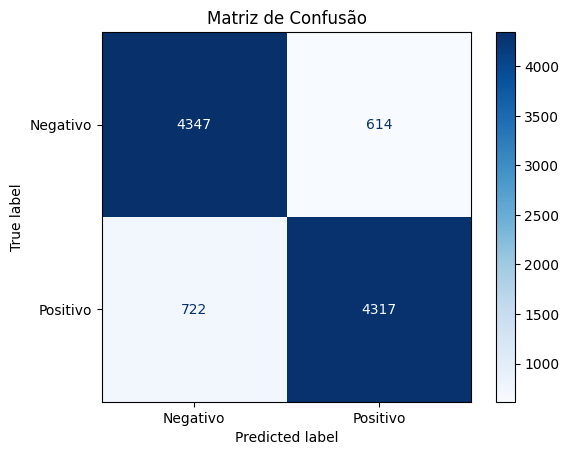

In [ ]:
# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Mostrar a matriz de confusão graficamente
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativo", "Positivo"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

# **7. Teste com Novos Exemplos**

In [ ]:
new_texts = ["This movie is superb!", "This is bad."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

predictions = (best_model.predict(new_padded_sequences) > 0.5).astype("int32")
print(predictions)  # 1 para positivo, 0 para negativo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[1]
 [0]]


# **8. Salvando resultados**

In [ ]:
best_model.save('best_model.h5')

In [ ]:
import pickle

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import files

files.download('best_model.h5')
files.download('tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>